In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from multiprocessing.pool import ThreadPool
from sklearn.metrics import mean_squared_error
import time
from collections import Counter


pool = ThreadPool(processes=1)

sns.set()

data = pd.read_csv('train.csv',nrows = 10000000)       # Contains the first 10 million data from                                                                       
    
training_set = data.sample(n = 1000000 , replace = False)    # 1 million random data from same distribution
dev_set = data.sample(n = 10000 , replace = False)           # 10000 random data from same distribution

# Shape, data type, data sample and descriptive statistics of Training Set

### Shape

In [0]:
training_set.shape

(1000000, 9)

### Data Type

In [0]:
training_set.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Data Sample

In [0]:
training_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,6846288,2014-08-14 01:36:34.0000001,6.5,2014-08-14 01:36:34 UTC,-73.975764,40.753898,-73.961381,40.769729,1
1,6026469,2015-02-24 09:56:15.0000005,6.0,2015-02-24 09:56:15 UTC,-73.974663,40.756310,-73.980339,40.760742,1
2,6472844,2014-01-14 20:12:06.0000001,5.5,2014-01-14 20:12:06 UTC,-73.970602,40.785972,-73.955813,40.783007,1
3,7672835,2012-04-06 07:02:34.0000001,8.1,2012-04-06 07:02:34 UTC,-74.007823,40.732122,-73.983278,40.761789,1
4,5340043,2009-03-29 20:33:54.0000002,7.4,2009-03-29 20:33:54 UTC,-73.996974,40.737093,-73.977298,40.729153,1


### Descriptive statistics 

In [0]:
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+06,1000000.000000,1000000.000000,1000000.000000,999992.000000,999992.000000,1000000.000000
mean,4.998324e+06,11.361415,-72.495018,39.922878,-72.504531,39.911158,1.685234
std,2.885680e+06,9.893425,12.260718,9.391801,12.781010,9.858497,1.346792
min,5.000000e+00,-107.750000,-2404.643242,-2875.860745,-3004.395947,-3271.296725,0.000000
25%,2.500745e+06,6.000000,-73.992062,40.734936,-73.991390,40.734032,1.000000
50%,4.997443e+06,8.500000,-73.981785,40.752627,-73.980137,40.753186,1.000000
75%,7.498032e+06,12.500000,-73.967091,40.767121,-73.963633,40.768122,2.000000
max,9.999971e+06,952.000000,2417.411523,2977.030610,2889.997293,3305.291182,208.000000


# Shape, data type, data sample and descriptive statistics of Development Set

### Shape

In [0]:
dev_set.shape

(10000, 9)

### Data Type

In [0]:
dev_set.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Data Sample

In [0]:
dev_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,5406611,2012-11-18 18:24:00.000000116,8.5,2012-11-18 18:24:00 UTC,-73.961455,40.765132,-73.976322,40.744262,1
1,6747269,2009-06-03 21:22:00.0000003,6.1,2009-06-03 21:22:00 UTC,-73.952222,40.787170,-73.963823,40.769275,1
2,327803,2010-10-23 23:45:50.0000003,20.1,2010-10-23 23:45:50 UTC,-74.004992,40.741375,-73.983108,40.670276,1
3,862905,2013-09-15 15:03:59.0000001,8.0,2013-09-15 15:03:59 UTC,-74.012050,40.715985,-74.012362,40.720336,2
4,9942124,2014-03-27 17:59:00.00000093,4.5,2014-03-27 17:59:00 UTC,-73.961375,40.760622,-73.954577,40.765732,1


### Descriptive statistics 

In [0]:
dev_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.035986e+06,11.476045,-72.470719,39.891178,-72.486662,39.903932,1.688500
std,2.884860e+06,10.124174,10.573926,6.275024,10.519467,6.237804,1.292453
min,2.840000e+02,0.010000,-75.338380,-74.010755,-78.562860,-74.002347,0.000000
25%,2.536053e+06,6.000000,-73.991816,40.734031,-73.991257,40.734249,1.000000
50%,5.044119e+06,8.500000,-73.981706,40.752599,-73.979504,40.753197,1.000000
75%,7.540420e+06,12.500000,-73.966705,40.767076,-73.963210,40.768144,2.000000
max,9.997197e+06,124.100000,40.770792,41.366138,40.778532,47.065774,6.000000


# Shape, data type, data sample and descriptive statistics of Test Set



### Shape

In [0]:
test_set.shape

(9914, 7)

### Data Type

In [0]:
test_set.dtypes

key                   object
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### Data Sample

In [0]:
test_set.head()

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1


### Descriptive statistics 

In [0]:
test_set.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


# Data Cleansing

## Removing Null values from the datasets

In [0]:
training_set.isnull().sum().sort_values(ascending = False)

dropoff_latitude     8
dropoff_longitude    8
passenger_count      0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
fare_amount          0
key                  0
Unnamed: 0           0
dtype: int64

In [0]:
dev_set.isnull().sum().sort_values(ascending = False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
fare_amount          0
key                  0
Unnamed: 0           0
dtype: int64

In [0]:
test_set.isnull().sum().sort_values(ascending = False)

passenger_count      0
dropoff_latitude     0
dropoff_longitude    0
pickup_latitude      0
pickup_longitude     0
pickup_datetime      0
key                  0
dtype: int64

In [0]:
training_set = training_set.drop(training_set[training_set.isnull().any(1)].index , axis = 0)
training_set.shape

(999992, 9)

In [0]:
dev_set = dev_set.drop(dev_set[dev_set.isnull().any(1)].index , axis = 0)
dev_set.shape

(10000, 9)

In [0]:
test_set = test_set.drop(test_set[test_set.isnull().any(1)].index , axis = 0)
test_set.shape

(9914, 7)

## Removing rows from the dataset having invalid data 

In [0]:
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.999920e+05,999992.000000,999992.000000,999992.000000,999992.000000,999992.000000,999992.000000
mean,4.998340e+06,11.361356,-72.495006,39.922871,-72.504531,39.911158,1.685247
std,2.885675e+06,9.893396,12.260767,9.391838,12.781010,9.858497,1.346789
min,5.000000e+00,-107.750000,-2404.643242,-2875.860745,-3004.395947,-3271.296725,0.000000
25%,2.500768e+06,6.000000,-73.992062,40.734936,-73.991390,40.734032,1.000000
50%,4.997454e+06,8.500000,-73.981785,40.752627,-73.980137,40.753186,1.000000
75%,7.498037e+06,12.500000,-73.967091,40.767121,-73.963633,40.768122,2.000000
max,9.999971e+06,952.000000,2417.411523,2977.030610,2889.997293,3305.291182,208.000000


In [0]:
training_set['fare_amount'].describe()

count    999992.000000
mean         11.361356
std           9.893396
min        -107.750000
25%           6.000000
50%           8.500000
75%          12.500000
max         952.000000
Name: fare_amount, dtype: float64

### Training_set is having negative value fare so we will remove those rows

In [0]:
Counter(training_set['fare_amount']<=0)

Counter({False: 999933, True: 59})

In [0]:
training_set = training_set.drop(training_set[training_set['fare_amount']<=0].index, axis=0)
training_set.shape

(999933, 9)

In [0]:
training_set['fare_amount'].describe()

count    999933.000000
mean         11.362526
std           9.891561
min           0.010000
25%           6.000000
50%           8.500000
75%          12.500000
max         952.000000
Name: fare_amount, dtype: float64

### Passenger count is greater than  7

In [0]:
training_set['passenger_count'].describe()

count    999933.000000
mean          1.685269
std           1.346816
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

In [0]:
#len(training_set[training_set['passenger_count']>7])

In [0]:
#### Since we are restricting to yellow cabs or medallion taxi. So we are considering 
#### a maximum of 7 passengers can operate in a taxi at a time.
Counter(training_set['passenger_count']>8)

Counter({False: 999930, True: 3})

In [0]:
training_set = training_set.drop(training_set[training_set['passenger_count']>8].index, axis = 0)
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.999300e+05,999930.000000,999930.000000,999930.000000,999930.000000,999930.000000,999930.000000
mean,4.998321e+06,11.362544,-72.495358,39.923065,-72.505106,39.911473,1.684729
std,2.885693e+06,9.891570,12.259856,9.391618,12.779551,9.858073,1.308652
min,5.000000e+00,0.010000,-2404.643242,-2875.860745,-3004.395947,-3271.296725,0.000000
25%,2.500702e+06,6.000000,-73.992062,40.734937,-73.991390,40.734034,1.000000
50%,4.997437e+06,8.500000,-73.981785,40.752627,-73.980137,40.753187,1.000000
75%,7.498034e+06,12.500000,-73.967093,40.767122,-73.963635,40.768122,2.000000
max,9.999971e+06,952.000000,2417.411523,2977.030610,2889.997293,3305.291182,6.000000


## Removing fare amount less than $2.5 and greater than $$500

In [0]:
print('\033[1m'+"Fare amount < 2.5: \n",training_set['fare_amount'][(training_set.fare_amount<2.5)].count())

Fare amount < 2.5: 
 18


In [0]:
print('\033[1m'+"Fare amount > 500: \n",training_set['fare_amount'][(training_set.fare_amount>500)].count())

Fare amount > 500: 
 1


In [0]:
training_set = training_set.drop(training_set[training_set['fare_amount'] < 2.5].index, axis = 0)
training_set = training_set.drop(training_set[training_set['fare_amount'] > 500].index, axis = 0)
training_set.shape

(999911, 9)

Text(0, 0.5, 'Frequency')

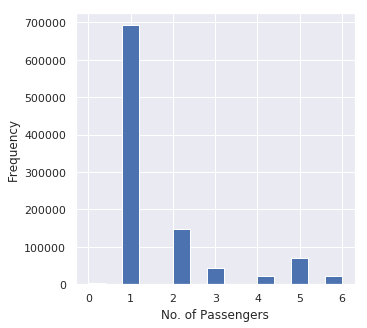

In [0]:
plt.figure(figsize=(5,5))
plt.hist(training_set['passenger_count'], bins=15)
plt.xlabel('No. of Passengers')
plt.ylabel('Frequency')

Text(0, 0.5, 'Fare')

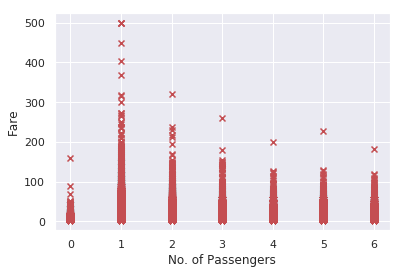

In [0]:
plt.scatter(x=training_set['passenger_count'], y=training_set['fare_amount'], c ='r' , marker = 'x')
plt.xlabel('No. of Passengers')
plt.ylabel('Fare')

### Removing invalid Longitude and Latitude 

In [0]:
training_set[['pickup_longitude','pickup_latitude']].describe()

,pickup_longitude,pickup_latitude
count,999911.000000,999911.000000
mean,-72.495404,39.923090
std,12.259756,9.391622
min,-2404.643242,-2875.860745
25%,-73.992062,40.734937
50%,-73.981785,40.752627
75%,-73.967093,40.767122
max,2417.411523,2977.030610


In [0]:
training_set[['dropoff_longitude','dropoff_latitude']].describe()

,dropoff_longitude,dropoff_latitude
count,999911.000000,999911.000000
mean,-72.505226,39.911539
std,12.779259,9.858005
min,-3004.395947,-3271.296725
25%,-73.991390,40.734034
50%,-73.980137,40.753187
75%,-73.963635,40.768122
max,2889.997293,3305.291182


#### Valid Longitude value = -180 to 180
#### Valid Latitude value = -90 to 90
#### Remove pickup cordinates and drop off cordinates which dont fall in this range 

##### Remove invalid pickup cordinates 

In [0]:
#print("Number of invalid pickup cordinates = ",len((training_set[training_set['pickup_latitude']<-90])|(training_set[training_set['pickup_latitude']>90])|(training_set[training_set['pickup_longitude']<-180])|(training_set[training_set['pickup_longitude']>180])))

In [0]:
training_set = training_set.drop(training_set[training_set['pickup_latitude']<-90].index,axis = 0)
training_set = training_set.drop(training_set[training_set['pickup_latitude']>90].index,axis = 0)
training_set = training_set.drop(training_set[training_set['pickup_longitude']<-180].index,axis = 0)
training_set = training_set.drop(training_set[training_set['pickup_longitude']>180].index, axis=0)
training_set.shape

(999883, 9)

#### Remove invalid drop off cordinates  

In [0]:
#print("Number of invalid drop off cordinates = ",len((training_set[training_set['dropoff_latitude']<-90])|(training_set[training_set['dropoff_latitude']>90])|(training_set[training_set['dropoff_longitude']<-180])|(training_set[training_set['dropoff_longitude']>180])))

In [0]:
training_set = training_set.drop(training_set[training_set['dropoff_latitude']<-90].index,axis = 0)
training_set = training_set.drop(training_set[training_set['dropoff_latitude']>90].index,axis = 0)
training_set = training_set.drop(training_set[training_set['dropoff_longitude']<-180].index,axis = 0)
training_set = training_set.drop(training_set[training_set['dropoff_longitude']>180].index, axis=0)
training_set.shape

(999865, 9)

In [0]:
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9.998650e+05,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000
mean,4.998320e+06,11.361776,-72.490613,39.913277,-72.499757,39.917879,1.684753
std,2.885694e+06,9.846678,10.481198,6.126783,10.447667,6.113381,1.308676
min,5.000000e+00,2.500000,-121.285595,-74.824164,-121.285388,-74.178840,0.000000
25%,2.500700e+06,6.000000,-73.992061,40.734937,-73.991390,40.734035,1.000000
50%,4.997435e+06,8.500000,-73.981785,40.752627,-73.980137,40.753187,1.000000
75%,7.498036e+06,12.500000,-73.967093,40.767120,-73.963635,40.768122,2.000000
max,9.999971e+06,500.000000,40.826712,73.979307,40.855685,73.992735,6.000000


## Distance between pick up location and drop off location
#### The distance in a sphere can be calculated when latitudes and longitudes are given by Haversine formula
#### haversine(θ) = sin²(θ/2)

#### φ is latitude, λ is longitude, R is earth’s radius (mean radius = 6,371km) to include latitude and longitude coordinates (A and B in this case).

#### a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)

#### c = 2 * atan2( √a, √(1−a) )

#### d = R ⋅ c

#### d = Haversine distance

In [0]:
def haversine_distance(data):
    R = 6371        # Radius of earth in Kilo Meter
    
    pickup_data = data[['pickup_longitude','pickup_latitude']]
    dropoff_data = data[['dropoff_longitude','dropoff_latitude']]
    
    phi1 = np.radians(pickup_data['pickup_latitude'])
    phi2 = np.radians(dropoff_data['dropoff_latitude'])
    
    delta_phi = np.radians(dropoff_data['dropoff_latitude'] - pickup_data['pickup_latitude'])
    delta_lambda = np.radians(dropoff_data['dropoff_longitude'] - pickup_data['pickup_longitude'])
    
    #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
    a = np.sin((delta_phi)/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(delta_lambda/2)**2
    
    #c = 2 * atan2( √a, √(1−a) )
    c = 2 * np.arctan2(np.sqrt(a),np.sqrt(1-a))
    d = R * c
    
    return d
    

### Finding Training set distance

In [0]:
training_set_distance = pd.DataFrame(haversine_distance(training_set) , columns=['Distance'])
training_set = pd.concat([training_set , training_set_distance] , axis = 1)

In [0]:
training_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
0,6846288,2014-08-14 01:36:34.0000001,6.5,2014-08-14 01:36:34 UTC,-73.975764,40.753898,-73.961381,40.769729,1,2.136860
1,6026469,2015-02-24 09:56:15.0000005,6.0,2015-02-24 09:56:15 UTC,-73.974663,40.756310,-73.980339,40.760742,1,0.686669
2,6472844,2014-01-14 20:12:06.0000001,5.5,2014-01-14 20:12:06 UTC,-73.970602,40.785972,-73.955813,40.783007,1,1.288050
3,7672835,2012-04-06 07:02:34.0000001,8.1,2012-04-06 07:02:34 UTC,-74.007823,40.732122,-73.983278,40.761789,1,3.893276
4,5340043,2009-03-29 20:33:54.0000002,7.4,2009-03-29 20:33:54 UTC,-73.996974,40.737093,-73.977298,40.729153,1,1.878308


Text(0, 0.5, 'Frequency')

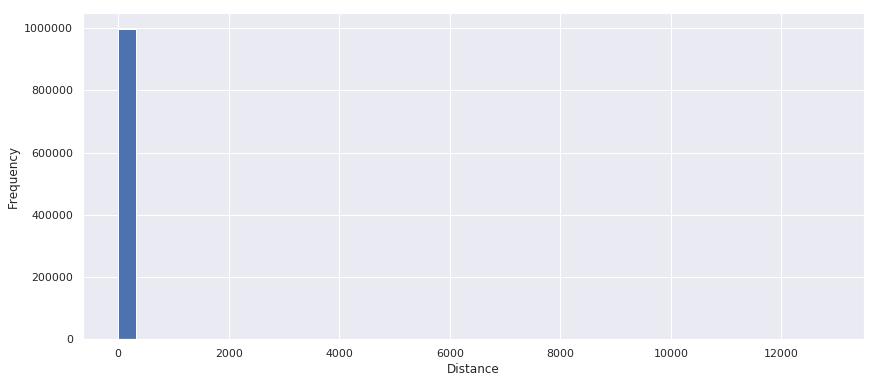

In [0]:
plt.figure(figsize=(14,6))
plt.hist(training_set['Distance'], bins=40)
plt.xlabel('Distance')
plt.ylabel('Frequency')

In [0]:
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
count,9.998650e+05,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000
mean,4.998320e+06,11.361776,-72.490613,39.913277,-72.499757,39.917879,1.684753,20.055550
std,2.885694e+06,9.846678,10.481198,6.126783,10.447667,6.113381,1.308676,373.382101
min,5.000000e+00,2.500000,-121.285595,-74.824164,-121.285388,-74.178840,0.000000,0.000000
25%,2.500700e+06,6.000000,-73.992061,40.734937,-73.991390,40.734035,1.000000,1.214251
50%,4.997435e+06,8.500000,-73.981785,40.752627,-73.980137,40.753187,1.000000,2.118853
75%,7.498036e+06,12.500000,-73.967093,40.767120,-73.963635,40.768122,2.000000,3.874906
max,9.999971e+06,500.000000,40.826712,73.979307,40.855685,73.992735,6.000000,12851.756269


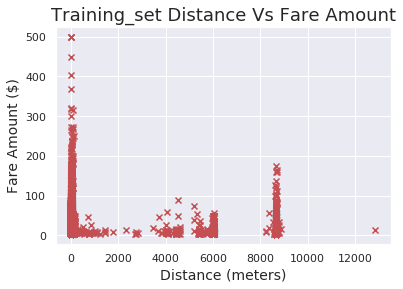

In [0]:
plt.scatter(training_set['Distance'] , training_set['fare_amount'] , c = 'r' , marker = 'x')
plt.title('Training_set Distance Vs Fare Amount',size = 18)
plt.xlabel('Distance (meters)',size = 14)
plt.ylabel('Fare Amount ($)',size = 14)
plt.show()

### Finding Dev set distance 

In [0]:
dev_set_distance = pd.DataFrame(haversine_distance(dev_set) , columns=['Distance'])
dev_set = pd.concat([dev_set , dev_set_distance] , axis = 1)

In [0]:
dev_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
0,5406611,2012-11-18 18:24:00.000000116,8.5,2012-11-18 18:24:00 UTC,-73.961455,40.765132,-73.976322,40.744262,1,2.636956
1,6747269,2009-06-03 21:22:00.0000003,6.1,2009-06-03 21:22:00 UTC,-73.952222,40.787170,-73.963823,40.769275,1,2.216669
2,327803,2010-10-23 23:45:50.0000003,20.1,2010-10-23 23:45:50 UTC,-74.004992,40.741375,-73.983108,40.670276,1,8.118205
3,862905,2013-09-15 15:03:59.0000001,8.0,2013-09-15 15:03:59 UTC,-74.012050,40.715985,-74.012362,40.720336,2,0.484523
4,9942124,2014-03-27 17:59:00.00000093,4.5,2014-03-27 17:59:00 UTC,-73.961375,40.760622,-73.954577,40.765732,1,0.806630


In [0]:
dev_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5.035986e+06,11.476045,-72.470719,39.891178,-72.486662,39.903932,1.688500,17.085071
std,2.884860e+06,10.124174,10.573926,6.275024,10.519467,6.237804,1.292453,339.691819
min,2.840000e+02,0.010000,-75.338380,-74.010755,-78.562860,-74.002347,0.000000,0.000000
25%,2.536053e+06,6.000000,-73.991816,40.734031,-73.991257,40.734249,1.000000,1.193600
50%,5.044119e+06,8.500000,-73.981706,40.752599,-73.979504,40.753197,1.000000,2.119014
75%,7.540420e+06,12.500000,-73.966705,40.767076,-73.963210,40.768144,2.000000,3.932044
max,9.997197e+06,124.100000,40.770792,41.366138,40.778532,47.065774,6.000000,8667.819475


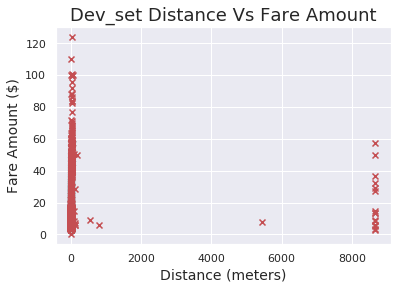

In [0]:
plt.scatter(dev_set['Distance'] , dev_set['fare_amount'] , c = 'r' , marker = 'x')
plt.title('Dev_set Distance Vs Fare Amount',size = 18)
plt.xlabel('Distance (meters)',size = 14)
plt.ylabel('Fare Amount ($)',size = 14)
plt.show()

## Support Vector Regression on Feature Distance 

In [0]:
def svr_linear(X,y):
    start_time = time.time()
    svr_lin = SVR(kernel='linear', C=7, gamma='auto')
    y_lin = svr_lin.fit(X, y)
    
    return svr_lin, start_time

def svr_RBF(X,y):
    start_time = time.time()
    svr_rbf = SVR(kernel='rbf', C=15, gamma=0.1, epsilon=.1)
    y_rbf = svr_rbf.fit(X, y)
    
    return svr_rbf, start_time

In [0]:
train_data = training_set.sample(n = 10000 , replace = False)
X = np.array(train_data['Distance']).reshape(len(train_data),1)
y = np.array(train_data['fare_amount'])

dev_data = dev_set.sample(n = 4256 , replace = False)
X_predict = np.array(dev_data['Distance']).reshape(len(dev_data),1)
y_predict = np.array(dev_data['fare_amount'])

In [0]:
t1 = pool.apply_async(svr_RBF, (X,y)) 
t2 = pool.apply_async(svr_linear, (X,y)) 

svr_rbf, rbf_start_time = t1.get()
svr_lin, lin_start_time = t2.get()

In [0]:
SVR_RBF_predict = svr_rbf.predict(X_predict)
SVR_Lin_predict = svr_lin.predict(X_predict)

SVR_RBF_mse = mean_squared_error(y_predict, SVR_RBF_predict)
SVR_Lin_mse = mean_squared_error(y_predict, SVR_Lin_predict)

SVR_RBF_rmse = np.sqrt(SVR_RBF_mse)
SVR_Lin_rmse = np.sqrt(SVR_Lin_mse)

print("Size of training data Set = ", len(train_data) ,"and size of validation data set = ", len(dev_data))
print("RMSE of Linear support vector regressor = " , SVR_Lin_rmse)
print("Run time of Linear support vector regressor = " , time.time() - lin_start_time  , "seconds")
print("\nRMSE of RBF support vector regressor = " , SVR_RBF_rmse)
print("Run time of RBF support vector regressor = " , time.time() - rbf_start_time , "seconds")

Size of training data Set =  10000 and size of validation data set =  4256
RMSE of Linear support vector regressor =  10.34886987612164
Run time of Linear support vector regressor =  141.01330637931824 seconds

RMSE of RBF support vector regressor =  5.140391089045284
Run time of RBF support vector regressor =  149.12658262252808 seconds


## From the above experiment we observed that the taxi fare doesn't depend only on distance. So, we need to add other features. 

### Checking data types of each column

In [0]:
training_set.dtypes

Unnamed: 0             int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
Distance             float64
dtype: object

### Considering traffic role in calculating fare amount i.e. at what time/day the taxi was hired will say us about that

### Key and pickup_datetime are datetime columns which are in object format. Convert them to datetime format

#### Converting Training set key and pickup_datetime to datetime

In [0]:
training_set['key'] = pd.to_datetime(training_set['key'])
training_set['pickup_datetime']  = pd.to_datetime(training_set['pickup_datetime'])

In [0]:
training_set.dtypes

Unnamed: 0                         int64
key                       datetime64[ns]
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
Distance                         float64
dtype: object

In [0]:
training_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
0,6846288,2014-08-14 01:36:34.000000100,6.5,2014-08-14 01:36:34+00:00,-73.975764,40.753898,-73.961381,40.769729,1,2.136860
1,6026469,2015-02-24 09:56:15.000000500,6.0,2015-02-24 09:56:15+00:00,-73.974663,40.756310,-73.980339,40.760742,1,0.686669
2,6472844,2014-01-14 20:12:06.000000100,5.5,2014-01-14 20:12:06+00:00,-73.970602,40.785972,-73.955813,40.783007,1,1.288050
3,7672835,2012-04-06 07:02:34.000000100,8.1,2012-04-06 07:02:34+00:00,-74.007823,40.732122,-73.983278,40.761789,1,3.893276
4,5340043,2009-03-29 20:33:54.000000200,7.4,2009-03-29 20:33:54+00:00,-73.996974,40.737093,-73.977298,40.729153,1,1.878308


#### Converting Dev set key and pickup_datetime to datetime

In [0]:
dev_set['key'] = pd.to_datetime(dev_set['key'])
dev_set['pickup_datetime']  = pd.to_datetime(dev_set['pickup_datetime'])

In [0]:
dev_set.dtypes

Unnamed: 0                         int64
key                       datetime64[ns]
fare_amount                      float64
pickup_datetime      datetime64[ns, UTC]
pickup_longitude                 float64
pickup_latitude                  float64
dropoff_longitude                float64
dropoff_latitude                 float64
passenger_count                    int64
Distance                         float64
dtype: object

In [0]:
dev_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance
0,5406611,2012-11-18 18:24:00.000000116,8.5,2012-11-18 18:24:00+00:00,-73.961455,40.765132,-73.976322,40.744262,1,2.636956
1,6747269,2009-06-03 21:22:00.000000300,6.1,2009-06-03 21:22:00+00:00,-73.952222,40.787170,-73.963823,40.769275,1,2.216669
2,327803,2010-10-23 23:45:50.000000300,20.1,2010-10-23 23:45:50+00:00,-74.004992,40.741375,-73.983108,40.670276,1,8.118205
3,862905,2013-09-15 15:03:59.000000100,8.0,2013-09-15 15:03:59+00:00,-74.012050,40.715985,-74.012362,40.720336,2,0.484523
4,9942124,2014-03-27 17:59:00.000000930,4.5,2014-03-27 17:59:00+00:00,-73.961375,40.760622,-73.954577,40.765732,1,0.806630


## Spliting the datetime field 'pickup_datetime' to the following -


*   year
*   month
*   date
*   hour
*   day of week

## Using these we shall calculate the day of the week

In [0]:
def date_time_conversion(data):
  time_data = data['pickup_datetime']
  
  year = time_data.dt.year
  month = time_data.dt.month
  date = time_data.dt.day
  hour = time_data.dt.hour
  day_of_week = time_data.dt.dayofweek
  
  values = {'year' : year , 'month' : month , 'date' : date , 'hour' : hour , 'day_of_week' : day_of_week} 
  
  return pd.DataFrame(data=values)

### Finding datetime for training set

In [0]:
training_set_time_value = date_time_conversion(training_set)
training_set = pd.concat([training_set , training_set_time_value] , axis = 1)

In [0]:
training_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,year,month,date,hour,day_of_week
0,6846288,2014-08-14 01:36:34.000000100,6.5,2014-08-14 01:36:34+00:00,-73.975764,40.753898,-73.961381,40.769729,1,2.136860,2014,8,14,1,3
1,6026469,2015-02-24 09:56:15.000000500,6.0,2015-02-24 09:56:15+00:00,-73.974663,40.756310,-73.980339,40.760742,1,0.686669,2015,2,24,9,1
2,6472844,2014-01-14 20:12:06.000000100,5.5,2014-01-14 20:12:06+00:00,-73.970602,40.785972,-73.955813,40.783007,1,1.288050,2014,1,14,20,1
3,7672835,2012-04-06 07:02:34.000000100,8.1,2012-04-06 07:02:34+00:00,-74.007823,40.732122,-73.983278,40.761789,1,3.893276,2012,4,6,7,4
4,5340043,2009-03-29 20:33:54.000000200,7.4,2009-03-29 20:33:54+00:00,-73.996974,40.737093,-73.977298,40.729153,1,1.878308,2009,3,29,20,6


In [0]:
training_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,year,month,date,hour,day_of_week
count,9.998650e+05,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000,999865.000000
mean,4.998320e+06,11.361776,-72.490613,39.913277,-72.499757,39.917879,1.684753,20.055550,2011.738549,6.264642,15.704057,13.507170,3.041121
std,2.885694e+06,9.846678,10.481198,6.126783,10.447667,6.113381,1.308676,373.382101,1.860891,3.433971,8.685325,6.514752,1.949901
min,5.000000e+00,2.500000,-121.285595,-74.824164,-121.285388,-74.178840,0.000000,0.000000,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,2.500700e+06,6.000000,-73.992061,40.734937,-73.991390,40.734035,1.000000,1.214251,2010.000000,3.000000,8.000000,9.000000,1.000000
50%,4.997435e+06,8.500000,-73.981785,40.752627,-73.980137,40.753187,1.000000,2.118853,2012.000000,6.000000,16.000000,14.000000,3.000000
75%,7.498036e+06,12.500000,-73.967093,40.767120,-73.963635,40.768122,2.000000,3.874906,2013.000000,9.000000,23.000000,19.000000,5.000000
max,9.999971e+06,500.000000,40.826712,73.979307,40.855685,73.992735,6.000000,12851.756269,2015.000000,12.000000,31.000000,23.000000,6.000000


### Finding datetime of dev set

In [0]:
dev_set_time_value = date_time_conversion(dev_set)
dev_set = pd.concat([dev_set , dev_set_time_value] , axis = 1)

In [0]:
dev_set.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,year,month,date,hour,day_of_week
0,5406611,2012-11-18 18:24:00.000000116,8.5,2012-11-18 18:24:00+00:00,-73.961455,40.765132,-73.976322,40.744262,1,2.636956,2012,11,18,18,6
1,6747269,2009-06-03 21:22:00.000000300,6.1,2009-06-03 21:22:00+00:00,-73.952222,40.787170,-73.963823,40.769275,1,2.216669,2009,6,3,21,2
2,327803,2010-10-23 23:45:50.000000300,20.1,2010-10-23 23:45:50+00:00,-74.004992,40.741375,-73.983108,40.670276,1,8.118205,2010,10,23,23,5
3,862905,2013-09-15 15:03:59.000000100,8.0,2013-09-15 15:03:59+00:00,-74.012050,40.715985,-74.012362,40.720336,2,0.484523,2013,9,15,15,6
4,9942124,2014-03-27 17:59:00.000000930,4.5,2014-03-27 17:59:00+00:00,-73.961375,40.760622,-73.954577,40.765732,1,0.806630,2014,3,27,17,3


In [0]:
dev_set.describe()

,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,Distance,year,month,date,hour,day_of_week
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5.035986e+06,11.476045,-72.470719,39.891178,-72.486662,39.903932,1.688500,17.085071,2011.772200,6.22090,15.776700,13.384300,3.100700
std,2.884860e+06,10.124174,10.573926,6.275024,10.519467,6.237804,1.292453,339.691819,1.856732,3.44736,8.682521,6.589109,1.943486
min,2.840000e+02,0.010000,-75.338380,-74.010755,-78.562860,-74.002347,0.000000,0.000000,2009.000000,1.00000,1.000000,0.000000,0.000000
25%,2.536053e+06,6.000000,-73.991816,40.734031,-73.991257,40.734249,1.000000,1.193600,2010.000000,3.00000,8.000000,9.000000,1.000000
50%,5.044119e+06,8.500000,-73.981706,40.752599,-73.979504,40.753197,1.000000,2.119014,2012.000000,6.00000,16.000000,14.000000,3.000000
75%,7.540420e+06,12.500000,-73.966705,40.767076,-73.963210,40.768144,2.000000,3.932044,2013.000000,9.00000,23.000000,19.000000,5.000000
max,9.997197e+06,124.100000,40.770792,41.366138,40.778532,47.065774,6.000000,8667.819475,2015.000000,12.00000,31.000000,23.000000,6.000000


### Support Vector Regression
#### Taking all feature of training_set into considertion  

In [0]:
training_set.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Distance', 'year', 'month',
       'date', 'hour', 'day_of_week'],
      dtype='object')

In [0]:
dev_set.columns

Index(['Unnamed: 0', 'key', 'fare_amount', 'pickup_datetime',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'passenger_count', 'Distance', 'year', 'month',
       'date', 'hour', 'day_of_week'],
      dtype='object')

### Exclude the pickup_datetime columns as datetime columns cannot be directly used while modeling. 


In [0]:
Data_training_set = training_set.drop(['key','pickup_datetime'], axis = 1)
Data_dev_set = dev_set.drop(['key','pickup_datetime'], axis = 1)

In [0]:
Data_training_set.columns

Index(['Unnamed: 0', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Distance',
       'year', 'month', 'date', 'hour', 'day_of_week'],
      dtype='object')

In [0]:
Data_dev_set.columns

Index(['Unnamed: 0', 'fare_amount', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count', 'Distance',
       'year', 'month', 'date', 'hour', 'day_of_week'],
      dtype='object')

In [0]:
training_data = Data_training_set.sample(n=10000 , replace = False)
x_train = np.array(training_data[[ 'Distance']])
y_train = np.array(training_data['fare_amount'])

dev_data = Data_dev_set.sample(n=1000 , replace = False)
x_val = np.array(dev_data[['Distance']])
y_val = np.array(dev_data['fare_amount'])

In [0]:
x_train.shape

(10000, 1)

In [0]:
y_train.shape

(10000,)

In [0]:
x_val.shape

(1000, 1)

In [0]:
y_val.shape

(1000,)

In [0]:
pool = ThreadPool(processes=1)

t3 = pool.apply_async(svr_RBF, (x_train,y_train)) 
t4 = pool.apply_async(svr_linear, (x_train,y_train)) 

svr_rbf, rbf_start_time = t3.get()
svr_lin, lin_start_time = t4.get()

In [0]:
SVR_RBF_predict = svr_rbf.predict(x_val)
SVR_Lin_predict = svr_lin.predict(x_val)

SVR_RBF_mse = mean_squared_error(y_val, SVR_RBF_predict)
SVR_Lin_mse = mean_squared_error(y_val, SVR_Lin_predict)

SVR_RBF_rmse = np.sqrt(SVR_RBF_mse)
SVR_Lin_rmse = np.sqrt(SVR_Lin_mse)

print("RMSE of Linear support vector regressor = " , SVR_Lin_rmse)
print("Run time of Linear support vector regressor = " , time.time() - lin_start_time , "seconds")
print("\nRMSE of RBF support vector regressor = " , SVR_RBF_rmse)
print("Run time of RBF support vector regressor = " , time.time() - rbf_start_time , "seconds")